## Predicting Balance of customers based on credit data

In [1]:
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from pandas.plotting import scatter_matrix
import seaborn as sns
import xlrd
from sklearn import datasets, linear_model, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

In [2]:
df1 = pd.read_csv("Credit.csv", index_col=False)
df1 = df1.drop("Unnamed: 0", axis=1)



## 2 (a) Select the training set: Randomly select 200 subjects into the training set, 100 for the model development set, and the remainder in the model evaluation set.

In [3]:
df1.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Gender, Student , Married and ethnicity are categorical and need to be encoded for further processing.

In [4]:
cat_preds = ['Ethnicity']
one_hot = pd.get_dummies(df1, columns=cat_preds)
one_hot = one_hot.drop('Ethnicity_Asian', axis=1) # as we need to retain n-1 variables when the variable has n levels

In [5]:
one_hot['Student'] = one_hot['Student'].apply(lambda x: 0 if x == 'No' else 1)
one_hot['Gender'] = one_hot['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
one_hot['Married'] = one_hot['Married'].apply(lambda x: 0 if x == 'No' else 1)

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(one_hot, one_hot['Balance'], test_size = 0.5, random_state=10)
X_dev, X_valid, Y_dev, Y_valid = train_test_split(X_test, Y_test, test_size = 0.5, random_state=10)

## 2 (b) Data exploration: Consider the training set only. Report one- and two-variable summary statistics (e.g., boxplots, histograms, scatterplots, correlations - limit the total number of plots, and only present those that are necessary). Discuss the implications of the exploration for the regression analysis (e.g., presence of highly correlated predictors, categorical predictors, missing values, outliers etc). Transform variables if needed.

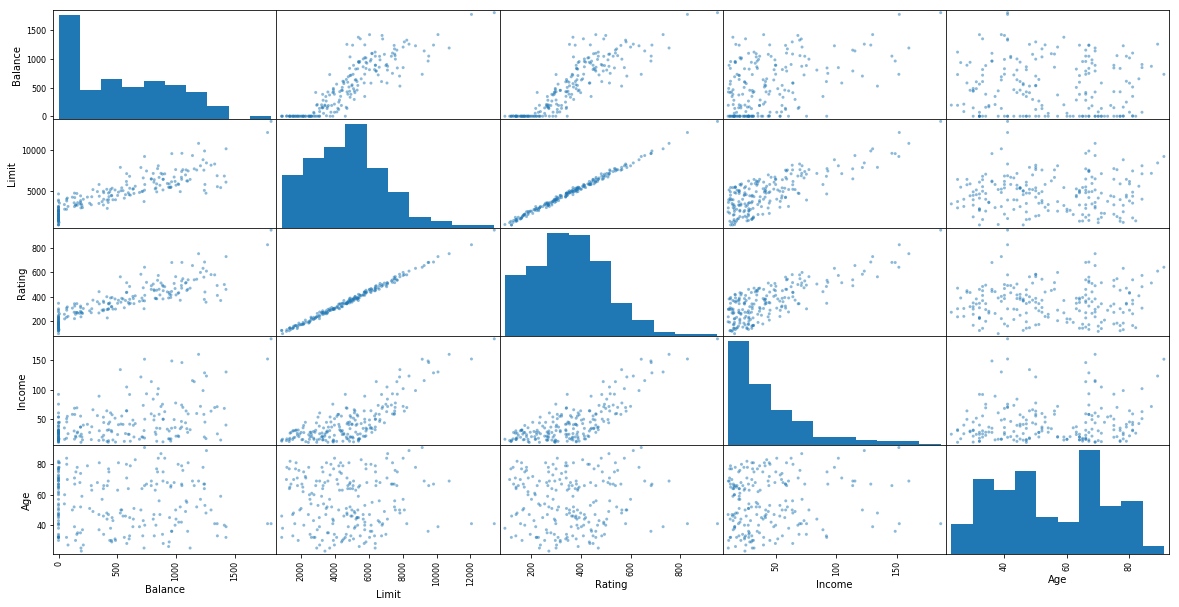

In [7]:
plt.rcParams["figure.figsize"] = (20, 10)
scatter_matrix(X_train[['Balance', 'Limit', 'Rating', 'Income', 'Age']])
plt.show()

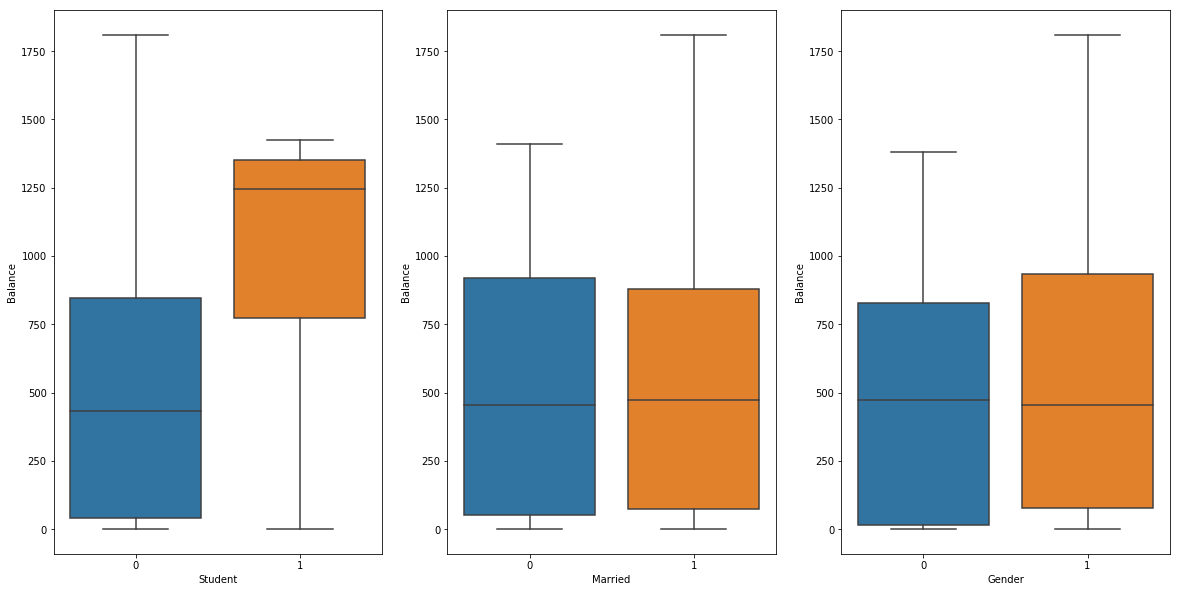

In [8]:
plt.subplot(1,3,1)
sns.boxplot(X_train['Student'], Y_train)
plt.subplot(1,3,2)
sns.boxplot(X_train['Married'], Y_train)
plt.subplot(1,3,3)
sns.boxplot(X_train['Gender'], Y_train)

In [119]:
len(Y_train[(Y_train == 0)])

46

Conclusions from data exploration:
1. There are 4 categorical predictors - Married, Student, Gender and Ethnicity
2. Since ethnicity has 3 levels, it was split using one-hot encoding
3. 22 % of the Balance values in the training set is 0. 
4. Income is slightly left skewed, however other quantitative predictors are uniformly distributed
5. Limit and rating are linearly dependent/ related.
6. Income is also related to limit and rating , which is expected as a person with higher income would have higher credit limit. 
7. There appears to be some relationship between Balance and Income, Limit and rating from the plots.
8. Being a student also impacts balance.





## 2 (c) Assumption of Normality: Consider the training set only. Fit linear regression with all predictors. Evaluate the plausibility of Normal linear regression and constant variance using a plot of the residuals obtained from the model with all the possible predictors. Transform balance if needed.

In [103]:
## Plain linear regression
X_train = X_train.drop('Balance', axis=1)
X_dev = X_dev.drop('Balance', axis =1)
X_valid = X_valid.drop('Balance', axis=1)
linear = linear_model.LinearRegression().fit(X_train, Y_train)

In [104]:
np.sqrt(mean_squared_error(Y_train, linear.predict(X_train)))

95.40696138164473

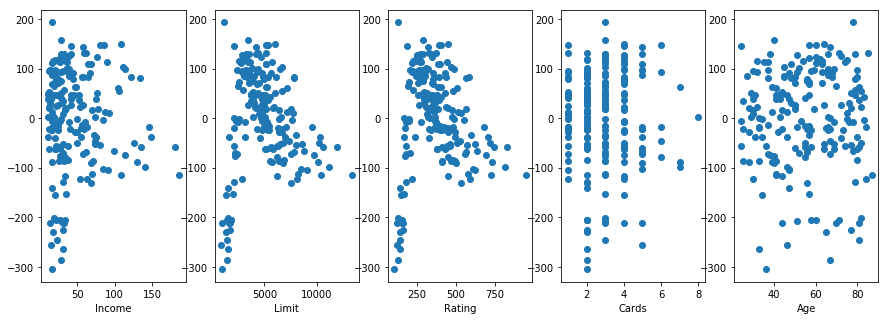

In [64]:
plt.rcParams["figure.figsize"] = (15, 5)
resid = linear.predict(X_train) - Y_train
cols = X_train.columns
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xlabel(cols[i])
    plt.scatter(X_train.iloc[:,i], resid)
    

We observe a systematic pattern in the residuals vs Income, Limit and Rating indicating that the model has not captured the true relationship between these variables and Balance.  Also since there are lot of zero values in balance,a log transformation will not help address this issue.

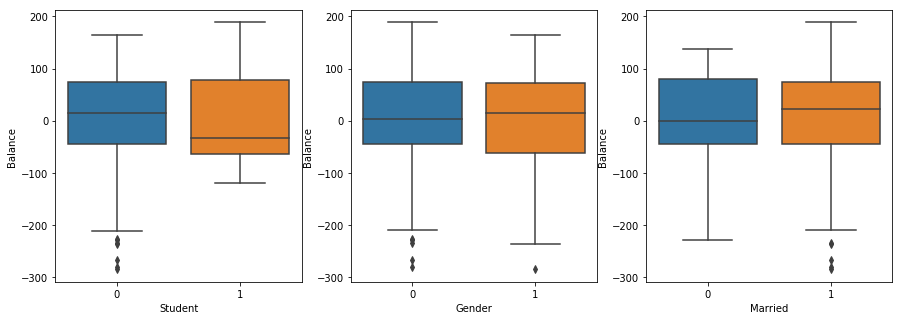

In [13]:
plt.subplot(1,3,1)
sns.boxplot(X_train['Student'], resid)
plt.subplot(1,3,2)
sns.boxplot(X_train['Gender'], resid)
plt.subplot(1,3,3)
sns.boxplot(X_train['Married'], resid)

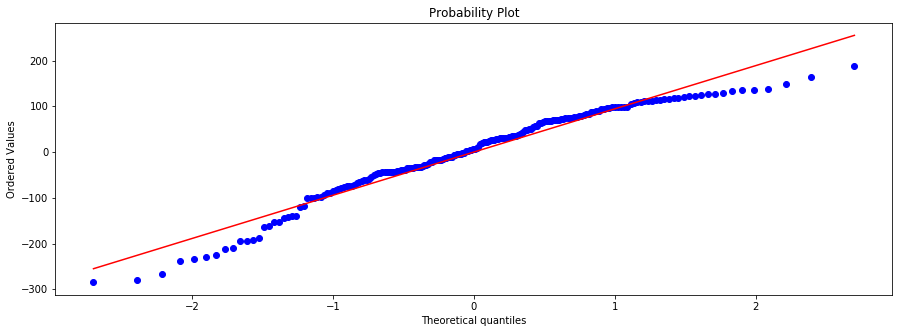

In [14]:
import pylab 
import scipy.stats as stats

stats.probplot(resid, dist="norm", plot=pylab)
pylab.show()

## 2(d) Variable selection: Perform variable selection using all subsets selection, by fitting the models on the training set and selecting the best performing subset using the model development set. [Hint: Consider appropriate coding for qualitative predictors].

In [105]:
from itertools import combinations
def generate_subsets(s):
    subsets = []
    for i in range(len(s) + 1):
        yield from combinations(s, i)
    
sub_sets = [set(sub_set) for sub_set in generate_subsets(X_train.columns)]
def search_predictors(X_train, Y_train):
    min_rmse = float('inf')
    optimal_preds = None
    for item in sub_sets:
        if len(item) == 0:
            continue
        fit1 = linear_model.LinearRegression()
        fit1.fit(X_train[list(item)], Y_train)
        score = mean_squared_error(fit1.predict(X_dev[list(item)]),Y_dev)
        if np.sqrt(score) < min_rmse:
            min_rmse = np.sqrt(score)
            optimal_preds = list(item)
    return min_rmse, optimal_preds

min_rmse, best_subset  = search_predictors(X_train, Y_train)
print("The lowest rmse obtained on the dev set : ", min_rmse) 
print("The subset that produced the lowest RMSE: ", best_subset)
    

The lowest rmse obtained on the dev set :  96.55606198590989
The subset that produced the lowest RMSE:  ['Limit', 'Income', 'Education', 'Student', 'Married', 'Rating', 'Age']


## 2 (e) Variable selection: Consider the training set only. Perform ridge regularization.

In [106]:
from sklearn.model_selection import cross_val_score
alphas = [ 0.01, 0.05, 0.1, 1, 2, 5, 10]
def model_cv(model, X_train, Y_train):
    return np.mean(np.sqrt(-cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')))

rmse_cv = [model_cv(linear_model.Ridge(alpha), X_train, Y_train) for alpha in alphas]


Text(0, 0.5, 'RMSE')

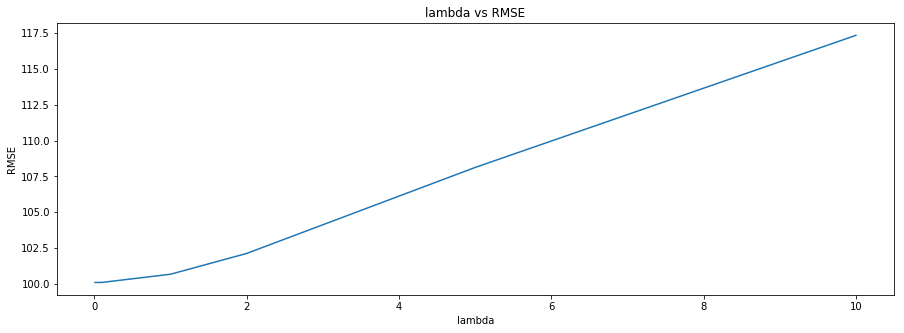

In [107]:
plt.plot(alphas, rmse_cv)
plt.title('lambda vs RMSE')
plt.xlabel("lambda")
plt.ylabel('RMSE')

In [108]:
rmse_cv = pd.Series(rmse_cv, index=alphas)
print("The lambda value corresponding to least rmse is:", rmse_cv.idxmin())
print("The lowest RMSE is: ", rmse_cv.min())
min_alpha = rmse_cv.idxmin()

The lambda value corresponding to least rmse is: 0.05
The lowest RMSE is:  100.08223699010448


In [109]:
# Using the selected lambda to fit on our training set
ridge_fit = linear_model.Ridge(min_alpha).fit(X_train, Y_train)
print("The RMSE on the development set is: ", np.sqrt(mean_squared_error(ridge_fit.predict(X_dev), Y_dev)))


The RMSE on the development set is:  102.63784322922116


## 2 (f) Variable selection: Consider the training set only. Perform variable selection using lasso regularization.

In [110]:
alphas = [0.1, 0.5, 1, 2, 5, 10, 20]

lasso_cv = [model_cv(linear_model.Lasso(alpha, max_iter=10000), X_train, Y_train) for alpha in alphas]


Text(0, 0.5, 'RMSE')

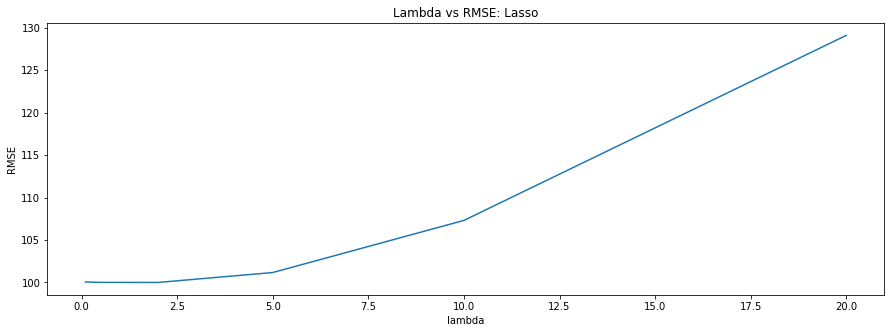

In [111]:
plt.title('Lambda vs RMSE: Lasso')
plt.plot(alphas, lasso_cv)
plt.xlabel("lambda")
plt.ylabel('RMSE')

In [112]:
lasso_cv = pd.Series(lasso_cv, index=alphas)
print("The lambda value corresponding to least rmse is:", lasso_cv.idxmin())
print("The lowest RMSE is: ", lasso_cv.min())
min_lambda = lasso_cv.idxmin()

The lambda value corresponding to least rmse is: 2.0
The lowest RMSE is:  99.99825995715892


In [113]:
# Fit a model using lambda = 0.01
lasso_fit = linear_model.Lasso(min_lambda, max_iter=10000).fit(X_train, Y_train)
print("The RMSE on the development set is: ", np.sqrt(mean_squared_error(lasso_fit.predict(X_dev), Y_dev)))

The RMSE on the development set is:  97.84114214519145


## 2 (g) Performance evaluation: Evaluate the performance of the models selected with all subsets, lasso and ridge regularization above, using the predictive accuracy onthe validation set. Which model performs best, and why?

In [114]:
## Predictive accuracy on validation set
#X_valid = X_valid.drop('Balance', axis=1)
linear_subset = ['Cards', 'Income', 'Limit', 'Student']
fit1 = linear_model.LinearRegression()
fit1.fit(X_train[linear_subset], Y_train)
print("The RMSE of Ordinary Least squares model : ", np.sqrt(mean_squared_error(Y_valid, fit1.predict(X_valid[linear_subset]))))

fit2 = linear_model.Ridge(alpha=min_alpha)
fit2.fit(X_train, Y_train)
print("The RMSE of Ridge model : ", np.sqrt(mean_squared_error(Y_valid, fit2.predict(X_valid))))

fit3 = linear_model.Lasso(alpha=min_lambda, max_iter=10000)
fit3.fit(X_train, Y_train)
print("The RMSE of Lasso model: " , np.sqrt(mean_squared_error(Y_valid, fit3.predict(X_valid))))




The RMSE of Ordinary Least squares model :  100.65439287785384
The RMSE of Ridge model :  104.29564064852109
The RMSE of Lasso model:  102.37006261352784


From the results we can see that Lasso performs well on the Validation set as compared to 
Ridge. Since Ridge penalizes the coefficients by a larger value there is an increased bias.   
The subset selection method is computationally expensive, hence Lasso performs a decent job by 
shrinking the less important coefficients to 0. 

## 2 (h) Interpretation of the results: Interpret the model with the best fit, using both English language description, and data/model visualization of your choice

Text(0, 0.5, 'Residuals')

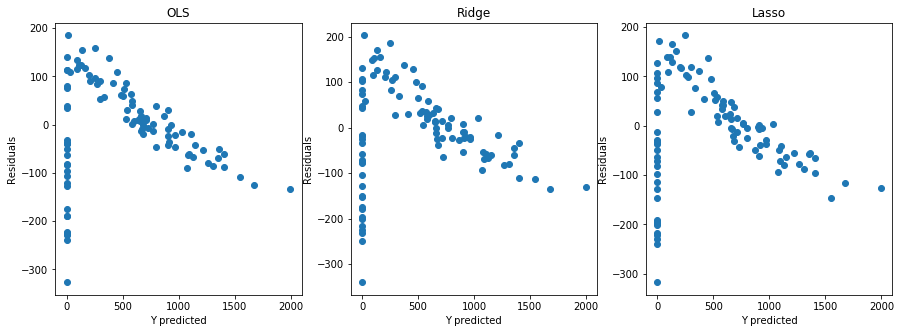

In [115]:
plt.subplot(1,3,1)
plt.title('OLS')
linear_resid = fit1.predict(X_valid[linear_subset]) - Y_valid
plt.scatter(Y_valid, linear_resid)
plt.xlabel('Y predicted')
plt.ylabel('Residuals')

plt.subplot(1,3,2)
plt.title('Ridge')
ridge_resid = fit2.predict(X_valid) - Y_valid
plt.scatter(Y_valid, ridge_resid)
plt.xlabel('Y predicted')
plt.ylabel('Residuals')
plt.subplot(1,3,3)
plt.title('Lasso')
lasso_resid = fit3.predict(X_valid) - Y_valid
plt.scatter(Y_valid, lasso_resid)
plt.xlabel('Y predicted')
plt.ylabel('Residuals')

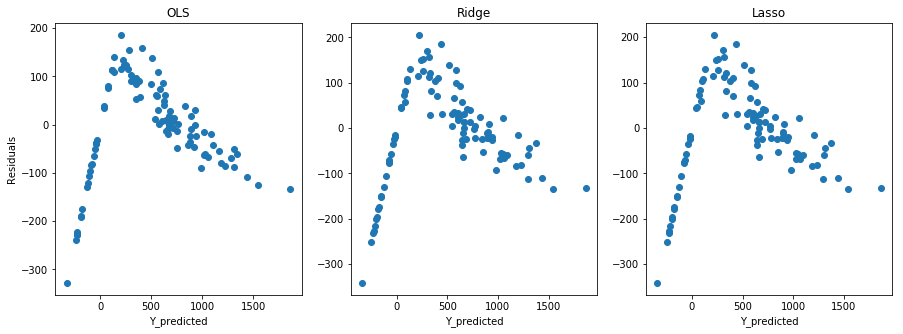

In [27]:
plt.subplot(1,3,1)
plt.title('OLS')
linear_resid = fit1.predict(X_valid[linear_subset]) - Y_valid
plt.xlabel('Y_predicted')
plt.ylabel('Residuals')
plt.scatter(fit1.predict(X_valid[linear_subset]), linear_resid)

plt.subplot(1,3,2)
plt.title('Ridge')
ridge_resid = fit2.predict(X_valid) - Y_valid
plt.xlabel('Y_predicted')
plt.scatter(fit2.predict(X_valid), ridge_resid)

plt.subplot(1,3,3)
plt.title('Lasso')
lasso_resid = fit3.predict(X_valid) - Y_valid
plt.xlabel('Y_predicted')
plt.scatter(fit3.predict(X_valid), lasso_resid)

As we see there is a systematic pattern in the residuals when compared to predicted values.
It means we can further improve the model. However the balance that we are trying to predict has 
0 values for some observations, and the current model would not predict this accurately. A better approach 
would be to fit 2 models in this case :
    1. To identify if the balance would be 0 or not
    2. If the balance is not 0 , then use a polynomial model to predict balance. 
    
 Model 1  can be looked upon as a case of classifying active and inactive credit card users (with balance 0)

    

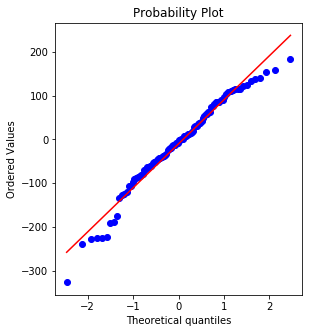

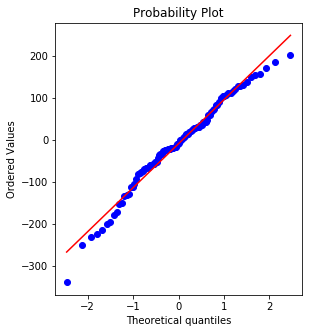

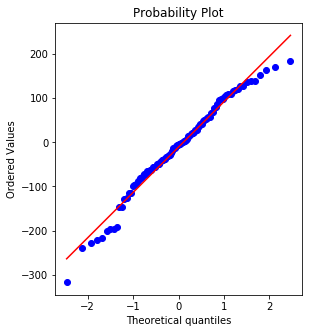

In [117]:
plt.subplot(1,3,1)
stats.probplot(linear_resid, dist="norm", plot=pylab)
pylab.show()
plt.subplot(1,3,2)
stats.probplot(ridge_resid, dist="norm", plot=pylab)
pylab.show()
plt.subplot(1,3,3)
stats.probplot(lasso_resid, dist="norm", plot=pylab)
pylab.show()

The qqplots of residuals corresponding to residuals from OLS, Ridge and lasso respectively 
on the evaluation set are almost comparable to one another. There is some deviation from the normal line, 
indicating that the true nature of the relationship has not be captured 


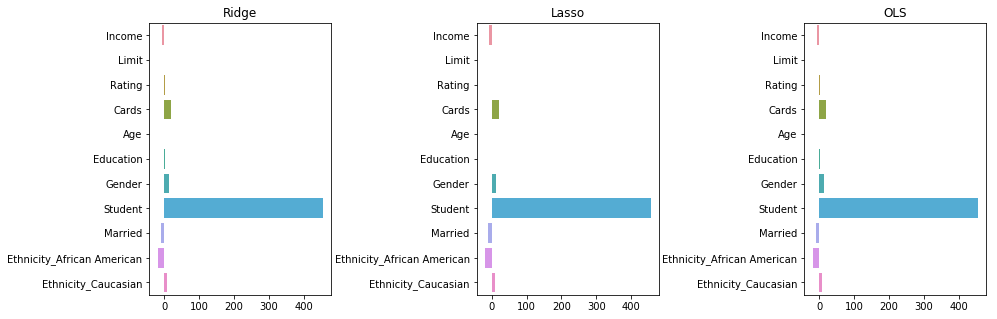

In [118]:
plt.subplots_adjust(wspace=0.8)
plt.subplot(1,3,1)
plt.title('Ridge')
sns.barplot(x = fit2.coef_, y = X_train.columns)
plt.subplot(1,3,2)
plt.title('Lasso')
sns.barplot(x = fit3.coef_, y = X_train.columns)
plt.subplot(1,3,3)
plt.title('OLS')
sns.barplot(x= linear.coef_, y=X_train.columns)


The above plots represent the coefficients obtained in each of the linear regression methods by including all predictors in the set. 
It is interesting however to see that the estimates are all comparable and regularization has 
not shrinked the parameters further. 
From the above observations , the linear model from the subset selection and lasso are both a good fit for the data.


## Additional inferences

Adding interaction terms to the linear Model using OLS , based on the subset selected and the correlation 
observed in the data exploration part, i.e
1. Including the interaction between Income and Rating
2. Including the interaction between Limit and Rating

In [30]:
X_train['Income_Rating'] = X_train['Income'] * X_train['Rating']
X_train['Limit_Rating'] = X_train['Limit'] * X_train['Rating']
X_valid['Income_Rating'] = X_valid['Income'] * X_valid['Rating']
X_valid['Limit_Rating'] = X_valid['Limit'] * X_valid['Rating']

In [31]:
linear_subset = ['Cards', 'Income', 'Limit', 'Student', 'Limit_Rating', 'Income_Rating']
fit1 = linear_model.LinearRegression()
fit1.fit(X_train[linear_subset], Y_train)
print("The RMSE of linear model : ", np.sqrt(mean_squared_error(Y_valid, fit1.predict(X_valid[linear_subset]))))



The RMSE of linear model :  79.82665816828698


Text(0, 0.5, 'Residuals')

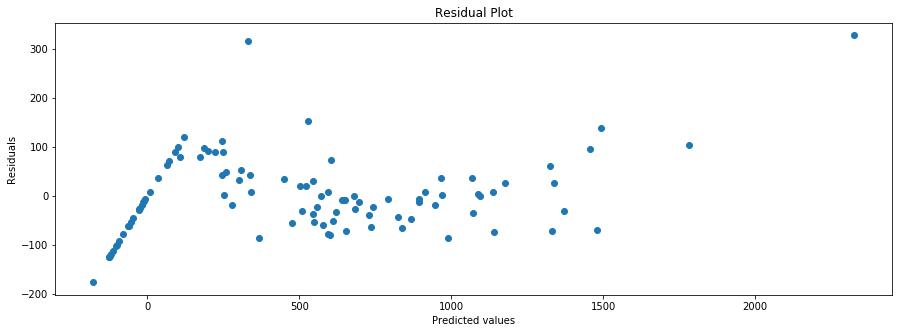

In [32]:
fit_resids = fit1.predict(X_valid[linear_subset]) - Y_valid
plt.title("Residual Plot")
plt.scatter(fit1.predict(X_valid[linear_subset]), fit_resids)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

By adding the interaction terms - Income \* Rating and Limit \* Rating in the linear model, the RMSE is further reduced
to 85.719. 
When the residuals were plotted against the predicted values we see that there is more randomness in the
residuals than before. However it is not yet a better model due to the existence of 0 values in Balance. 
In the qqplot below , the residuals are now more aligned with the normal distribution. 


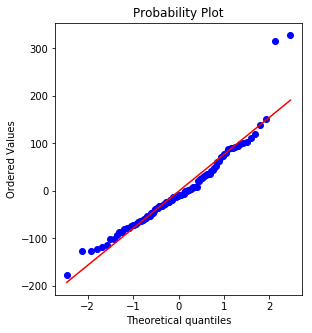

In [33]:
plt.subplot(1,3,1)
stats.probplot(fit_resids, dist="norm", plot=pylab)
pylab.show()